In [45]:
#Importing libraries
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
from pylab import rcParams
from plotly import tools
#import plotly.plotly as py
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
import math
from sklearn.metrics import mean_squared_error
#print(os.listdir("../input"))

In [2]:
dataframe0 = pd.read_csv("./train.csv")
#dataframe1 = pd.read_csv('./building_1_anolomy.csv')
#dataframe1 = pd.read_csv('./building_2_anolomy.csv')
#dataframe1 = pd.read_csv('./building_3_anolomy.csv')
#dataframe1 = pd.read_csv('./building_4_anolomy.csv')
dataframe1 = pd.read_csv('./building_5_anolomy.csv')

In [3]:
interval = [dataframe1.shape[0]]#, dataframe2.shape[0], dataframe3.shape[0], dataframe4.shape[0], dataframe5.shape[0]]

dataframe = dataframe1#pd.concat([dataframe1, dataframe2, dataframe3, dataframe4, dataframe5], axis = 0)
print("The shape of raw data is -: ", dataframe.shape)


dataframe = dataframe.drop(['Unnamed: 0'],axis=1)
print(dataframe.info())
dataframe['timestamp']=pd.to_datetime(dataframe['timestamp'],format='%d-%m-%Y %H:%M')
dataframe0['timestamp']=pd.to_datetime(dataframe0['timestamp'],format='%Y-%m-%d %H:%M:%S')


dataframe.set_index(dataframe['timestamp'],inplace=True)
dataframe = dataframe.drop(['timestamp'],axis=1)
dataframe.reset_index(inplace=True)

dataframe0.set_index(dataframe0['timestamp'],inplace=True)
dataframe0 = dataframe0.drop(['timestamp'],axis=1)
dataframe0.reset_index(inplace=True)

dataframe0.index = dataframe0['timestamp']
dataframe.index = dataframe['timestamp']
time_series = dataframe[['main_meter', 'sub_meter_1', 'sub_meter_2', 'corporate', 'day of week_0','day of week_1','day of week_2','day of week_3','day of week_4','day of week_5','day of week_6','building_number_1','building_number_2','building_number_3','building_number_4','building_number_5']] #'building_number','Hour', 'day of week']]#

dummy_test_data = dataframe0[['main_meter','sub_meter_1', 'sub_meter_2']]


The shape of raw data is -:  (6600, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 22 columns):
timestamp            6600 non-null object
timestamp.1          6600 non-null object
main_meter           6600 non-null float64
sub_meter_1          6600 non-null float64
sub_meter_2          6600 non-null float64
weekend              6600 non-null int64
corporate            6600 non-null int64
main_meter_4         6600 non-null float64
main_meter_12        6600 non-null float64
day of week_0        6600 non-null int64
day of week_1        6600 non-null int64
day of week_2        6600 non-null int64
day of week_3        6600 non-null int64
day of week_4        6600 non-null int64
day of week_5        6600 non-null int64
day of week_6        6600 non-null int64
building_number_1    6600 non-null int64
building_number_2    6600 non-null int64
building_number_3    6600 non-null int64
building_number_4    6600 non-null int64
building_number_5    

In [4]:
building5_intial = dataframe['main_meter'].copy()

In [9]:
building5_pred_actual = building5_intial[-val_length:-val_length+198]

In [6]:
from numpy import newaxis
from keras.layers.core import Dense ,Activation,Dropout
from keras.layers.recurrent import LSTM,GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler


Using TensorFlow backend.


In [7]:
##LSTM forecasting for the data

val_time = 1
n_input = 72
n_features = 16
val_length = int(float(dataframe1.shape[0])*0.2)
n_pred = 3

val_gap = val_time*4

sum = 0
#splitting into train and test data
for i, c in enumerate(interval):
	print(i)
	if (i == 0):
		train_data = time_series[:c-val_length]
		test_data = time_series[c-val_length:c]
		actual_test_data = dummy_test_data[(c-val_length)*val_gap:c*val_gap]
	else:
		train_data = pd.concat([train_data, time_series[sum:sum+c-val_length]])
		test_data = pd.concat([test_data, time_series[sum+c-val_length:sum+c]])
		actual_test_data = pd.concat([actual_test_data, dummy_test_data[(sum+c-val_length)*val_gap:(sum+c)*val_gap]])
	sum += c
	interval[i] = sum - (i+1)*val_length

test_data = pd.DataFrame(test_data).values.reshape(-1,n_features)
train_data = pd.DataFrame(train_data).values.reshape(-1,n_features)
df_test = actual_test_data.copy()
actual_test_data = actual_test_data.to_numpy()
actual_test_data = actual_test_data.reshape(-1, n_pred)


0


In [10]:
#starting with intialization 
scaler = MinMaxScaler()

scaler.fit(time_series)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)


from keras.preprocessing.sequence import TimeseriesGenerator

X_train = []
y_train = []

for j, c in enumerate(interval):
	if (j==0):
		# print(n_input)
		for i in range(n_input, c):
			X_train.append(scaled_train_data[i-n_input:i, :])
			y_train.append(scaled_train_data[i, :n_pred])
	else:
		# print(interval[j-1]+n_input)
		for i in range(interval[j-1]+n_input, c):
			X_train.append(scaled_train_data[i-n_input:i, :])
			y_train.append(scaled_train_data[i, :n_pred])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], n_input, n_features))

perm = np.random.permutation(X_train.shape[0])
X_train = X_train[perm]
y_train = y_train[perm]

print("Shape of training data after final processing -: ", X_train.shape)


Shape of training data after final processing -:  (5208, 72, 16)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras import losses
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD

In [12]:
val = "building5_1hr_sigmoid_3meter_adam_1_try"
'''
lstm_model = Sequential()
lstm_model.add(GRU(300,  return_sequences=True, activation='relu',input_shape=(n_input,n_features)))
lstm_model.add(GRU(50, return_sequences=True, activation='relu'))
lstm_model.add(GRU(50,activation='relu'))
lstm_model.add(Dense(3, activation='sigmoid'))

# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
lstm_model.compile(optimizer='adam',loss='mse')

print(lstm_model.summary())

model_json = lstm_model.to_json()
with open("./Json/model_LSTM_model_all_"+ val +".json", "w") as json_file:
    json_file.write(model_json)


lstm_model.fit(X_train, y_train, epochs=40, batch_size = 1024)

lstm_model.save_weights("./weights/model_LSTM_model_all_"+ val +".h5")
print("Saved model to disk")
'''
json_file = open("./Json/model_LSTM_model_all_"+ val +".json", 'r')
loaded_model_json = json_file.read()
json_file.close()
lstm_model = model_from_json(loaded_model_json)
print(lstm_model.summary())
# load weights into new model
lstm_model.load_weights("./weights/model_LSTM_model_all_"+ val +".h5")
print("Loaded model from disk")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 72, 300)           286200    
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                52800     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 339,153
Trainable params: 339,153
Non-trainable params: 0
_________________________________________________________________
None
Loaded model from disk


In [13]:
lstm_predictions_scaled = list()

sum = 0
for c in interval:
	batch = scaled_train_data[c-n_input:c, :]
	current_batch = batch.reshape((1,n_input,n_features))
	for i in range(sum, sum+val_length):   
		# print((lstm_model.predict(current_batch)).astype(np.float64))
		lstm_pred = ((lstm_model.predict(current_batch)).astype(np.float64))
		# print(train_data[c-n_input+i-sum,1], test_data[i][1])
		#print(lstm_pred, scaled_test_data[i][0], test_data[i][0])
		dummy = test_data[i].copy()
		dummy[:n_pred] = lstm_pred
		lstm_predictions_scaled.append(dummy)
		current_batch = np.append(current_batch[:,1:],[dummy.reshape(1, -1)], axis=1)
	sum += val_length

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
pred = np.array(lstm_predictions[:, :n_pred])
gru_before_repeat_pred = pred.copy()
pred = np.repeat(pred, val_gap, axis = 0)
print(pred.shape)
# exit()
print(actual_test_data.shape)
pred = pred.reshape(-1, n_pred)
# for i in range(pred.shape[0]):
# 	print(pred[i][0], actual_test_data[i][0])
print(pred.shape, actual_test_data.shape)

def evalution_metric(m,m_hat,timestamp):
    Dt=timestamp.day
    Dt = Dt.to_numpy()
    # Dt = np.repeat(Dt, val_gap)
    print(Dt.shape)
    Sum=0
    for i in range(len(m)):
        Sum+=np.power((m[i]-m_hat[i]),2)*np.exp(-(np.log(2)/100)*Dt[i])
    score=(1/np.mean(m))*(np.sqrt(Sum))
    return score

# #calculating metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

sum = 0
pred_main_meter_1_building5 = pred[sum:sum+val_length*4,0]
for j, c in enumerate(interval):
	print("########################### For Building "+str(j)+"###########################")	
	for i in range(n_pred):
		mean_squared_error_lstm = mse(actual_test_data[sum:sum+val_length,i], pred[sum:sum+val_length,i])
		# mean_squared_log_error_lstm = msle(test_data,lstm_predictions)
		print("METER "+str(i+1)+"-: ")
		print(mean_squared_error_lstm**0.5)
		print(evalution_metric(actual_test_data[sum:sum+val_length,i],pred[sum:sum+val_length, i],df_test[sum:sum+val_length].index))
	sum += val_length

(5280, 3)
(5280, 3)
(5280, 3) (5280, 3)
########################### For Building 0###########################
METER 1-: 
1893.710992742224
(1320,)
14.696090081380564
METER 2-: 
705.1017788049509
(1320,)
19.978605041486148
METER 3-: 
500.0013882828455
(1320,)
49.79705078367725


In [84]:
building1_main_meter_pred = pd.DataFrame(pred_main_meter1_building)
building1_main_meter_pred.columns = ['Main_meter']
building1_main_meter_pred.index = df_test[0:val_length*4].index

In [85]:
building1_main_meter_pred.to_csv('main_meter_ankan.csv')

In [95]:
pred_sub_meter_2_building4 = pd.DataFrame(pred_sub_meter_2_building4)
pred_sub_meter_2_building4.columns = ['Sub_meter_2']
pred_sub_meter_2_building4.index = df_test[0:val_length*4].index

In [96]:
pred_sub_meter_2_building4.to_csv('sub_meter_2_ankan.csv')

In [128]:
pred_sub_meter_1_building5 = pd.DataFrame(pred_sub_meter_1_building5)
pred_sub_meter_1_building5.columns = ['Sub_meter_1']
pred_sub_meter_1_building5.index = df_test[0:val_length*4].index

In [130]:
pred_sub_meter_1_building5.to_csv('sub_meter_1_ankan.csv')

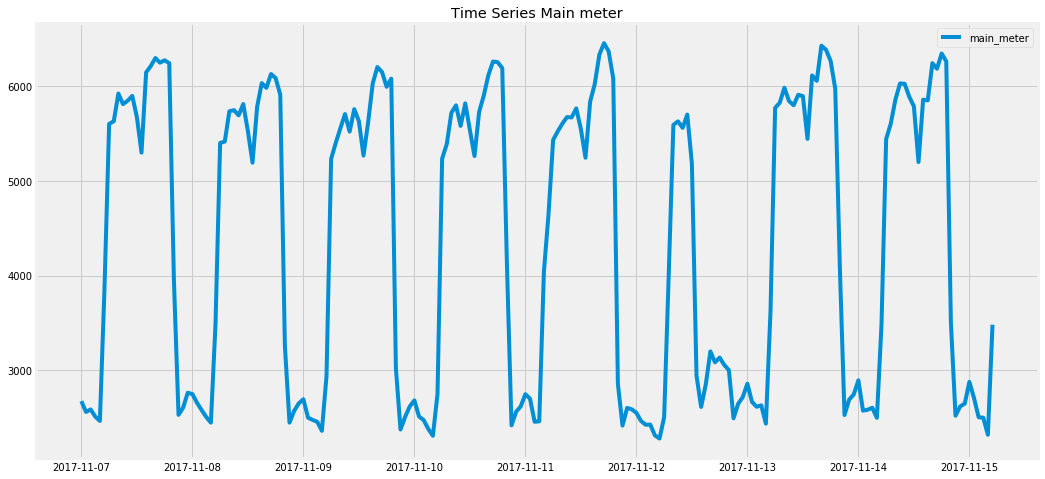

In [42]:
##Visualizing predictions by GRU
plt.figure(figsize=(16,8))
plt.plot(building5_pred_actual,label='main_meter')
plt.plot(final_test_pred='o',label='LSTM predictions')
plt.title('Time Series Main meter')
plt.legend(loc='best')

In [23]:
gru_predictions = pd.Series(pred_main_meter_1_building5[:198])
gru_predictions.index = building5_pred_actual.index

In [152]:
main_test_data = pd.Series(actual_test_data[0:val_length*4,0])
main_test_data.index = df_test[0:val_length*4].index

In [30]:
final_test_pred = pd.Series(gru_before_repeat_pred[:198,0])
final_test_pred.index = building5_pred_actual.index

In [184]:
arima_pred = pd.read_csv('arima_pred.csv')
arima_pred = arima_pred['0']
arima_pred = pd.Series(arima_pred)
arima_pred.index = building5_pred_actual.index

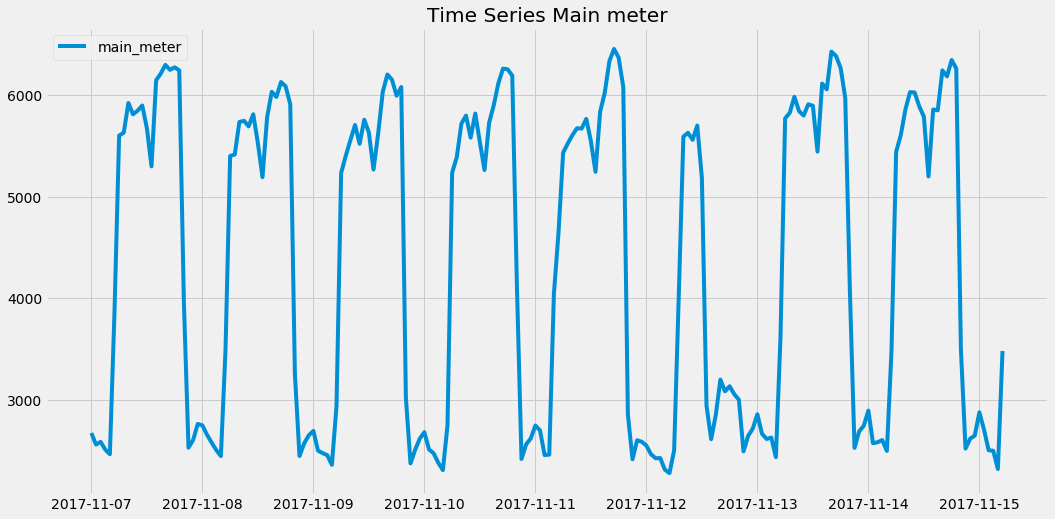

In [47]:
##Visualizing predictions by LSTM
plt.figure(figsize=(16,8))
plt.plot(building5_pred_actual,label='main_meter')
#plt.plot(final_test_pred='o',label='LSTM predictions')
plt.title('Time Series Main meter')
plt.legend(loc='best')

In [52]:
test_file = pd.read_csv('/home/vedant/Data_analytics/Data_Analytics_GC/test.csv')

In [57]:
test_file = test_file.drop(['Unnamed: 0'],axis=1)

In [63]:
test_file

,timestamp,weekend,corporate,day of week_0,day of week_1,day of week_2,day of week_3,day of week_4,day of week_5,day of week_6,building_number_1,building_number_2,building_number_3,building_number_4,building_number_5
0,2018-01-01 00:00:00,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,2018-01-01 01:00:00,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,2018-01-01 02:00:00,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,2018-01-01 03:00:00,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,2018-01-01 04:00:00,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12903,2018-04-18 09:00:00,0,1,0,0,1,0,0,0,0,0,0,0,0,1
12904,2018-04-18 10:00:00,0,1,0,0,1,0,0,0,0,0,0,0,0,1
12905,2018-04-18 11:00:00,0,1,0,0,1,0,0,0,0,0,0,0,0,1
12906,2018-04-18 12:00:00,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [62]:
test_file['timestamp'] = pd.to_datetime(test_file['timestamp'],format='%Y-%m-%d %H:%M:%S')